# A notebook to create the dataset

In [3]:
import pandas as pd
import numpy as np

def load_and_prepare_timeseries_data(csv_path, sequence_length=10, overlap=0, dt=0.016):
    """
    Loads CSV data and creates timeseries sequences with integrated positions.
    
    Args:
        csv_path (str): Path to the CSV file
        sequence_length (int): Number of steps per timeseries sequence
        overlap (int): Number of overlapping steps between sequences (0 to sequence_length-1)
        dt (float): Time step for Euler integration (default 0.016)
    
    Returns:
        pd.DataFrame: DataFrame with timeseries sequences and integrated x, y, theta values
    """
    # Load data
    df = pd.read_csv(csv_path)
    
    # Extract relevant columns
    columns_to_keep = ['vx', 'vy', 'omega', 'vx_cmd', 'vy_cmd', 'omega_cmd']
    df_stripped = df[columns_to_keep].copy()
    
    # Calculate stride (distance between sequence starts)
    stride = sequence_length - overlap
    
    sequences = []
    integrated_positions = []
    
    # Create timeseries sequences
    for start_idx in range(0, len(df_stripped) - sequence_length + 1, stride):
        end_idx = start_idx + sequence_length
        sequence = df_stripped.iloc[start_idx:end_idx].copy()
        
        # Initialize position and heading
        x, y, theta = 0.0, 0.0, 0.0
        positions = [(0.0, 0.0, 0.0)]  # Start at origin
        
        # Euler integration for each step in the sequence
        for idx, row in sequence.iterrows():
            vx = row['vx']
            vy = row['vy']
            omega = row['omega']
            
            # Update heading
            theta += omega * dt
            # Wrap theta to -pi to pi
            theta = np.arctan2(np.sin(theta), np.cos(theta))
            
            # Update position in global frame
            x += vx * dt
            y += vy * dt
            
            positions.append((x, y, theta))
        
        # Store sequence and its integrated positions
        sequences.append(sequence)
        integrated_positions.append(positions)
    
    # Create output dataframe with sequences and integrated values
    result_rows = []
    
    for seq_idx, (sequence, positions) in enumerate(zip(sequences, integrated_positions)):
        # Convert sequence to dictionary format
        seq_dict = {}
        
        # Add velocity/command data with sequence index
        for col in columns_to_keep:
            seq_dict[col] = sequence[col].values.tolist()
        
        # Add integrated positions
        seq_dict['integrated_x'] = [pos[0] for pos in positions]
        seq_dict['integrated_y'] = [pos[1] for pos in positions]
        seq_dict['integrated_theta'] = [pos[2] for pos in positions]
        
        # Add sequence metadata
        seq_dict['sequence_idx'] = seq_idx
        seq_dict['start_row'] = sequence.index[0]
        seq_dict['end_row'] = sequence.index[-1]
        
        result_rows.append(seq_dict)
    
    # Convert to DataFrame (each row is a sequence)
    result_df = pd.DataFrame(result_rows)
    
    return result_df

# Usage example
result = load_and_prepare_timeseries_data(
    '../dataset/processed_data/data0.csv',
    sequence_length=50,  # 50 timesteps per sequence
    overlap=10,          # 10 timesteps overlap between sequences
    dt=0.016
)

print(f"Total sequences created: {len(result)}")
print("\nFirst sequence structure:")
print(result.iloc[0])
print(f"\nSequence length (should be {50}): {len(result.iloc[0]['vx'])}")
print(f"Integrated positions (first 5): {list(zip(result.iloc[0]['integrated_x'][:5], result.iloc[0]['integrated_y'][:5]))}")

Total sequences created: 225

First sequence structure:
vx                  [0.0, -0.0475375368729135, -0.0688344105558744...
vy                  [0.0, 0.2786346713943993, 0.3968733798243557, ...
omega               [0.0, -0.1379521819970328, -0.3086789923058558...
vx_cmd              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
vy_cmd              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
omega_cmd           [-3.41724, -3.65059, -3.86224, -4.06502, -4.23...
integrated_x        [0.0, 0.0, -0.000760600589966616, -0.001861951...
integrated_y        [0.0, 0.0, 0.004458154742310389, 0.01080812881...
integrated_theta    [0.0, 0.0, -0.002207234911952525, -0.007146098...
sequence_idx                                                        0
start_row                                                           0
end_row                                                            49
Name: 0, dtype: object

Sequence length (should be 50): 50
Integrated positions (first 5): [(0.0, 0.0), 

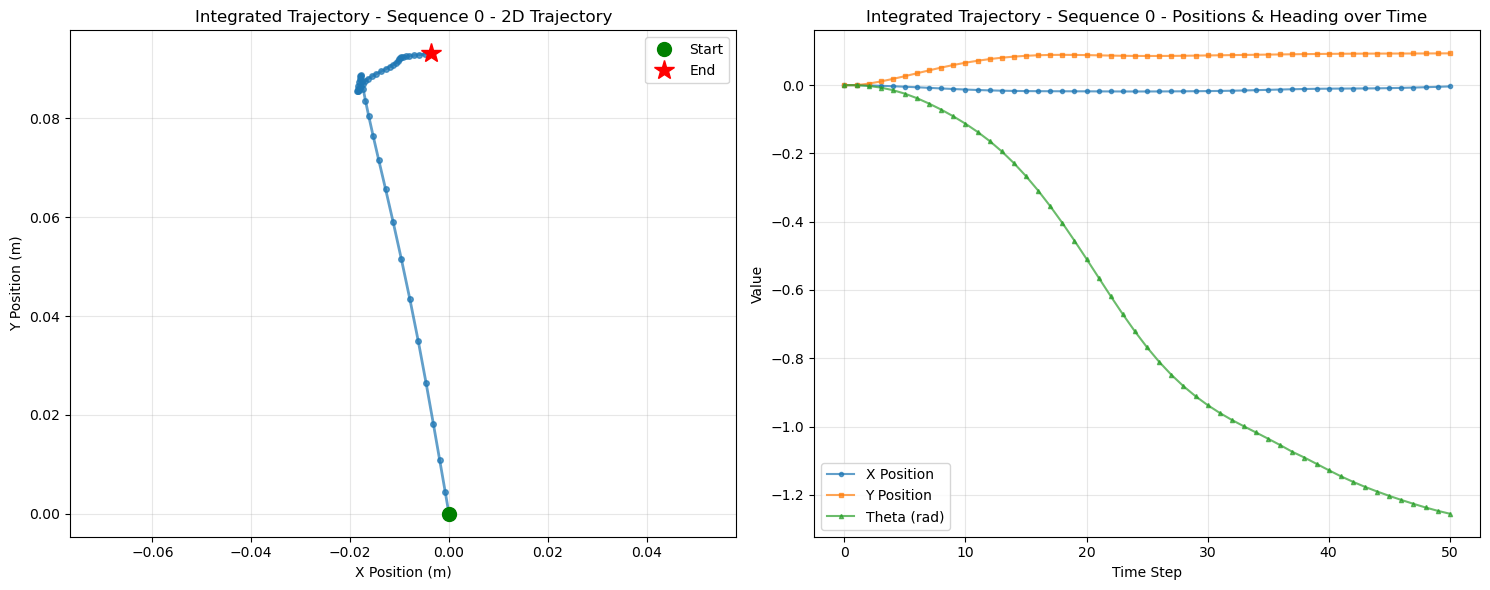

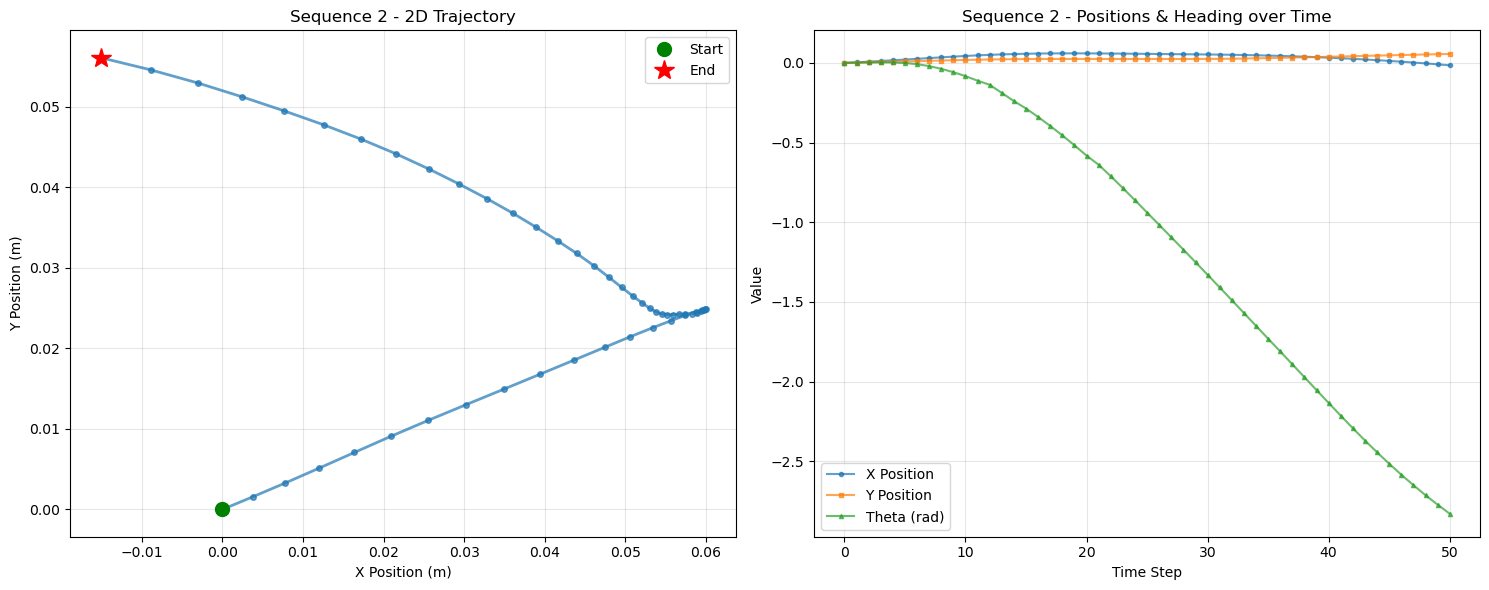

In [4]:
import matplotlib.pyplot as plt

def plot_timeseries_trajectory(timeseries_row, title=None):
    """
    Plots the integrated trajectory for a single timeseries datapoint.
    
    Args:
        timeseries_row: A single row from the result DataFrame containing integrated positions
        title (str): Optional title for the plot. If None, uses sequence index.
    """
    # Extract integrated positions
    x_positions = timeseries_row['integrated_x']
    y_positions = timeseries_row['integrated_y']
    theta_positions = timeseries_row['integrated_theta']
    
    # Set default title
    if title is None:
        seq_idx = timeseries_row['sequence_idx']
        title = f"Integrated Trajectory - Sequence {seq_idx}"
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: 2D Trajectory
    axes[0].plot(x_positions, y_positions, linewidth=2, marker='o', markersize=4, alpha=0.7)
    axes[0].plot(x_positions[0], y_positions[0], 'go', markersize=10, label='Start')
    axes[0].plot(x_positions[-1], y_positions[-1], 'r*', markersize=15, label='End')
    axes[0].set_xlabel('X Position (m)')
    axes[0].set_ylabel('Y Position (m)')
    axes[0].set_title(f"{title} - 2D Trajectory")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].axis('equal')
    
    # Plot 2: Position and Heading over time
    time_steps = range(len(x_positions))
    axes[1].plot(time_steps, x_positions, label='X Position', marker='o', markersize=3, alpha=0.7)
    axes[1].plot(time_steps, y_positions, label='Y Position', marker='s', markersize=3, alpha=0.7)
    axes[1].plot(time_steps, theta_positions, label='Theta (rad)', marker='^', markersize=3, alpha=0.7)
    axes[1].set_xlabel('Time Step')
    axes[1].set_ylabel('Value')
    axes[1].set_title(f"{title} - Positions & Heading over Time")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Usage example
# Plot the first sequence
plot_timeseries_trajectory(result.iloc[0])

# Plot a specific sequence with custom title
plot_timeseries_trajectory(result.iloc[2], title="Sequence 2")

Total input/target sequences: 225

First sequence info:
Input steps: 1
Target steps: 25


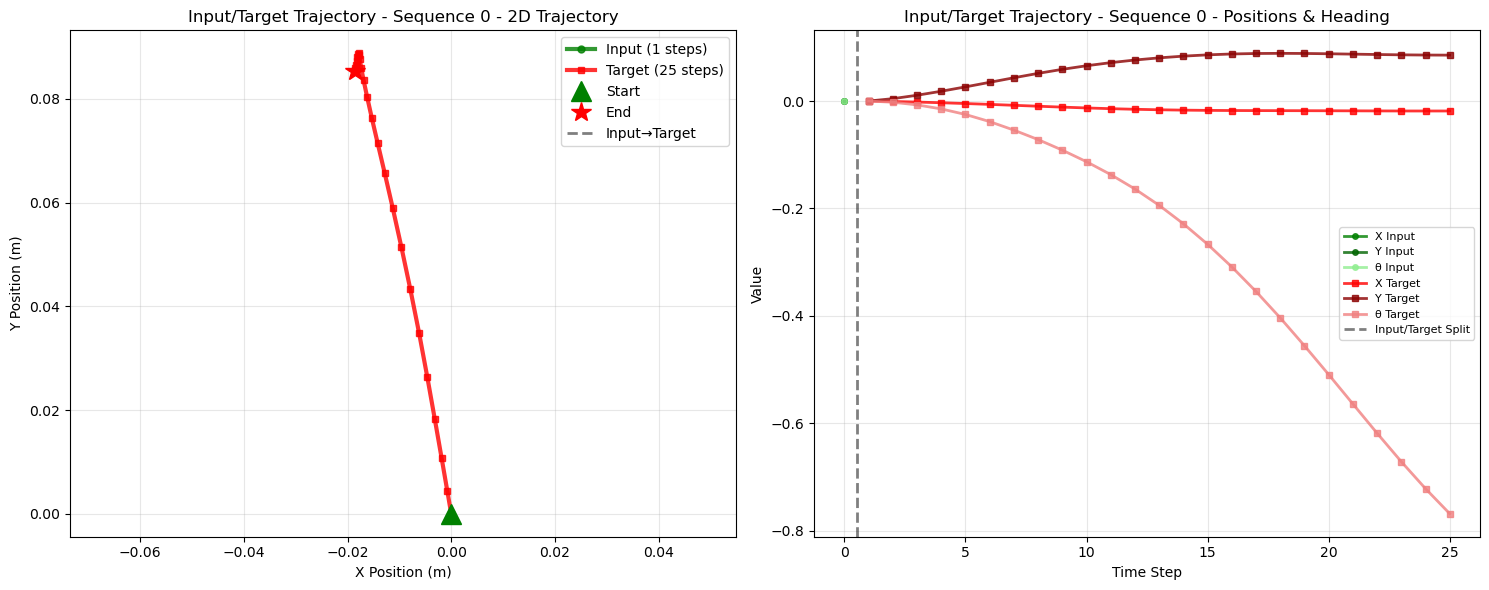

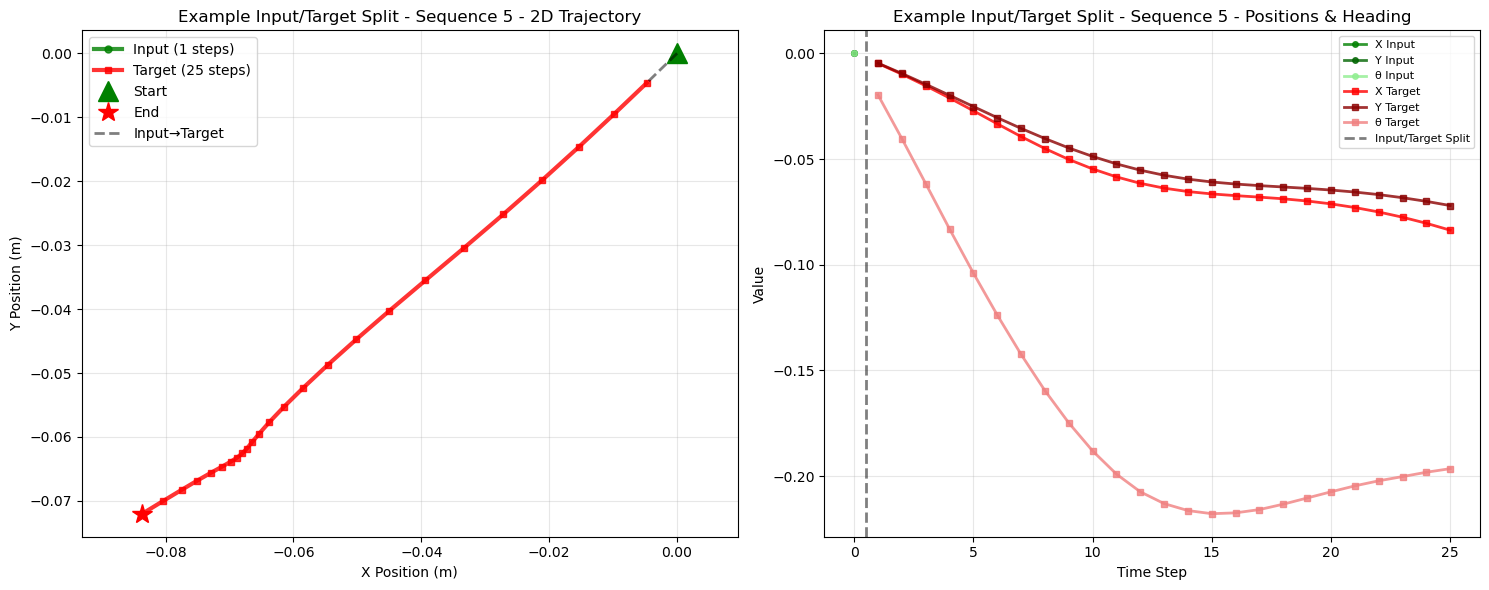

In [5]:
def create_input_target_sequences(result_df, input_steps=20, target_steps=10):
    """
    Creates input and target sequences from timeseries data.
    
    Args:
        result_df: DataFrame from load_and_prepare_timeseries_data()
        input_steps (int): Number of steps for input (X)
        target_steps (int): Number of steps for target (Y)
    
    Returns:
        pd.DataFrame: DataFrame with input and target sequences
    """
    sequences = []
    sequence_length = input_steps + target_steps
    
    for idx, row in result_df.iterrows():
        # Check if sequence is long enough
        if len(row['vx']) < sequence_length:
            continue
        
        # Extract input portion (first X steps)
        input_dict = {
            'vx_input': row['vx'][:input_steps],
            'vy_input': row['vy'][:input_steps],
            'omega_input': row['omega'][:input_steps],
            'vx_cmd_input': row['vx_cmd'][:input_steps],
            'vy_cmd_input': row['vy_cmd'][:input_steps],
            'omega_cmd_input': row['omega_cmd'][:input_steps],
            'x_input': row['integrated_x'][:input_steps],
            'y_input': row['integrated_y'][:input_steps],
            'theta_input': row['integrated_theta'][:input_steps],
        }
        
        # Extract target portion (next Y steps)
        target_dict = {
            'vx_target': row['vx'][input_steps:sequence_length],
            'vy_target': row['vy'][input_steps:sequence_length],
            'omega_target': row['omega'][input_steps:sequence_length],
            'vx_cmd_target': row['vx_cmd'][input_steps:sequence_length],
            'vy_cmd_target': row['vy_cmd'][input_steps:sequence_length],
            'omega_cmd_target': row['omega_cmd'][input_steps:sequence_length],
            'x_target': row['integrated_x'][input_steps:sequence_length],
            'y_target': row['integrated_y'][input_steps:sequence_length],
            'theta_target': row['integrated_theta'][input_steps:sequence_length],
        }
        
        # Merge metadata
        metadata = {
            'original_sequence_idx': row['sequence_idx'],
            'input_steps': input_steps,
            'target_steps': target_steps,
        }
        
        sequence_data = {**input_dict, **target_dict, **metadata}
        sequences.append(sequence_data)
    
    return pd.DataFrame(sequences)


def plot_input_target_trajectory(input_target_row, title=None):
    """
    Plots the integrated trajectory with input and target portions highlighted.
    
    Args:
        input_target_row: A single row from the input/target DataFrame
        title (str): Optional title for the plot. If None, uses sequence index.
    """
    # Extract positions
    x_input = input_target_row['x_input']
    y_input = input_target_row['y_input']
    theta_input = input_target_row['theta_input']
    
    x_target = input_target_row['x_target']
    y_target = input_target_row['y_target']
    theta_target = input_target_row['theta_target']
    
    # Combine for full trajectory
    x_full = x_input + x_target
    y_full = y_input + y_target
    theta_full = theta_input + theta_target
    
    input_steps = input_target_row['input_steps']
    total_steps = input_steps + input_target_row['target_steps']
    
    # Set default title
    if title is None:
        seq_idx = input_target_row['original_sequence_idx']
        title = f"Input/Target Trajectory - Sequence {seq_idx}"
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: 2D Trajectory with input/target separation
    axes[0].plot(x_input, y_input, linewidth=3, marker='o', markersize=5, 
                 alpha=0.8, color='green', label=f'Input ({input_steps} steps)')
    axes[0].plot(x_target, y_target, linewidth=3, marker='s', markersize=5, 
                 alpha=0.8, color='red', label=f'Target ({len(x_target)} steps)')
    
    # Add start and end markers
    axes[0].plot(x_input[0], y_input[0], 'g^', markersize=15, label='Start')
    axes[0].plot(x_target[-1], y_target[-1], 'r*', markersize=15, label='End')
    
    # Add connection point (transition from input to target)
    axes[0].plot([x_input[-1], x_target[0]], [y_input[-1], y_target[0]], 
                 'k--', linewidth=2, alpha=0.5, label='Input→Target')
    
    axes[0].set_xlabel('X Position (m)')
    axes[0].set_ylabel('Y Position (m)')
    axes[0].set_title(f"{title} - 2D Trajectory")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].axis('equal')
    
    # Plot 2: Position and Heading over time with input/target separation
    time_input = range(len(x_input))
    time_target = range(len(x_input), len(x_full))
    
    # Plot input phase
    axes[1].plot(time_input, x_input, marker='o', markersize=4, alpha=0.8, 
                 color='green', linewidth=2, label='X Input')
    axes[1].plot(time_input, y_input, marker='o', markersize=4, alpha=0.8, 
                 color='darkgreen', linewidth=2, label='Y Input')
    axes[1].plot(time_input, theta_input, marker='o', markersize=4, alpha=0.8, 
                 color='lightgreen', linewidth=2, label='θ Input')
    
    # Plot target phase
    axes[1].plot(time_target, x_target, marker='s', markersize=4, alpha=0.8, 
                 color='red', linewidth=2, label='X Target')
    axes[1].plot(time_target, y_target, marker='s', markersize=4, alpha=0.8, 
                 color='darkred', linewidth=2, label='Y Target')
    axes[1].plot(time_target, theta_target, marker='s', markersize=4, alpha=0.8, 
                 color='lightcoral', linewidth=2, label='θ Target')
    
    # Add vertical line to separate input and target
    axes[1].axvline(x=input_steps - 0.5, color='black', linestyle='--', 
                    linewidth=2, alpha=0.5, label='Input/Target Split')
    
    axes[1].set_xlabel('Time Step')
    axes[1].set_ylabel('Value')
    axes[1].set_title(f"{title} - Positions & Heading")
    axes[1].legend(loc='best', fontsize=8)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


# Usage example
input_target_data = create_input_target_sequences(
    result,
    input_steps=1,     # First 25 steps are input
    target_steps=25     # Next 25 steps are target
)

print(f"Total input/target sequences: {len(input_target_data)}")
print(f"\nFirst sequence info:")
print(f"Input steps: {input_target_data.iloc[0]['input_steps']}")
print(f"Target steps: {input_target_data.iloc[0]['target_steps']}")

# Plot first sequence
plot_input_target_trajectory(input_target_data.iloc[0])

# Plot another sequence
plot_input_target_trajectory(input_target_data.iloc[5], 
                            title="Example Input/Target Split - Sequence 5")

In [6]:
input_target_data.head()

,vx_input,vy_input,omega_input,vx_cmd_input,vy_cmd_input,omega_cmd_input,x_input,y_input,theta_input,vx_target,...,omega_target,vx_cmd_target,vy_cmd_target,omega_cmd_target,x_target,y_target,theta_target,original_sequence_idx,input_steps,target_steps
0,[0.0],[0.0],[0.0],[0.0],[0.0],[-3.41724],[0.0],[0.0],[0.0],"[-0.0475375368729135, -0.0688344105558744, -0....",...,"[-0.1379521819970328, -0.3086789923058558, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-3.65059, -3.86224, -4.06502, -4.23785, -4.36...","[0.0, -0.000760600589966616, -0.00186195115886...","[0.0, 0.004458154742310389, 0.0108081288195000...","[0.0, -0.002207234911952525, -0.00714609878884...",0,1,25
1,[0.0166465551073193],[0.0185129910776125],[-1.1106991398955728],[0.0],[0.0],[-0.498588],[0.0],[0.0],[0.0],"[0.0119016874725003, 0.0139300448188297, 0.021...",...,"[-1.0159102118639038, -0.929195596112551, -0.8...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.464739, -0.438788, -0.412463, -0.384715, -...","[0.0002663448817171088, 0.0004567718812771136,...","[0.0002962078572418, 0.0005072444786716992, 0....","[-0.017771186238329163, -0.03402574962815162, ...",1,1,25
2,[0.2369562888583255],[0.0987756130086162],[0.1074334472986627],[0.0],[0.0],[-16.5108],[0.0],[0.0],[0.0],"[0.2517982019541692, 0.2631890525216847, 0.271...",...,"[0.0748836266313559, 0.0327793953410309, -0.05...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-16.5011, -16.4789, -16.4279, -16.3199, -16.1...","[0.0037913006217332084, 0.007820071852999915, ...","[0.0015804098081378592, 0.003291885961161531, ...","[0.0017189351567786031, 0.0029170731828802978,...",2,1,25
3,[-0.2171434970320301],[0.1142747086792729],[-5.001345577521527],[-1.334134147431699],[4.070250445276091e-05],[0.210109],[0.0],[0.0],[0.0],"[-0.2356733755555708, -0.2530083224842938, -0....",...,"[-4.925184643784749, -4.804491044471932, -4.63...","[-1.3312693848054111, -1.3281753385055493, -1....","[0.0001100173715427, 0.0001473454088872, 0.000...","[0.669538, 1.09581, 1.48456, 1.87212, 2.23568,...","[-0.0034742959525124817, -0.007245069961401614...","[0.0018283953388683665, 0.0037036696464649247,...","[-0.08002152924034445, -0.15882448354090042, -...",3,1,25
4,[-0.1275684634214243],[-0.1782532790841842],[2.82155588440158],[-0.9931497291266476],[-0.5806045507578003],[-0.173213],[0.0],[0.0],[0.0],"[-0.1248988342957039, -0.1090628599138862, -0....",...,"[2.671127019733861, 2.216611790485765, 1.78212...","[-0.9901678988840644, -0.9904503256606924, -0....","[-0.5816664463801546, -0.5811854052052824, -0....","[-0.387519, -0.387519, -0.387519, -0.920938, -...","[-0.002041095414742789, -0.0040394767634740515...","[-0.0028520524653469475, -0.006200374231410972...","[0.045144894150425274, 0.08788292646616705, 0....",4,1,25


In [7]:
import torch
from torch.utils.data import Dataset

class RobotTrajectoryDataset(Dataset):
    """
    PyTorch Dataset for robot trajectory sequences with input and target splits.
    """
    
    def __init__(self, result_df, input_steps=20, target_steps=10):
        """
        Initialize the dataset.
        
        Args:
            result_df: DataFrame from load_and_prepare_timeseries_data()
            input_steps (int): Number of input steps
            target_steps (int): Number of target steps
        """
        self.input_steps = input_steps
        self.target_steps = target_steps
        self.sequence_length = input_steps + target_steps
        
        # Create input/target sequences
        self.sequences = []
        
        for idx, row in result_df.iterrows():
            # Check if sequence is long enough
            if len(row['vx']) < self.sequence_length:
                continue
            
            # Create input data
            input_data = {
                'vx': np.array(row['vx'][:input_steps], dtype=np.float32),
                'vy': np.array(row['vy'][:input_steps], dtype=np.float32),
                'omega': np.array(row['omega'][:input_steps], dtype=np.float32),
                'vx_cmd': np.array(row['vx_cmd'][:input_steps], dtype=np.float32),
                'vy_cmd': np.array(row['vy_cmd'][:input_steps], dtype=np.float32),
                'omega_cmd': np.array(row['omega_cmd'][:input_steps], dtype=np.float32),
                'x': np.array(row['integrated_x'][:input_steps], dtype=np.float32),
                'y': np.array(row['integrated_y'][:input_steps], dtype=np.float32),
                'theta': np.array(row['integrated_theta'][:input_steps], dtype=np.float32),
            }
            
            # Create target data
            target_data = {
                'vx': np.array(row['vx'][input_steps:self.sequence_length], dtype=np.float32),
                'vy': np.array(row['vy'][input_steps:self.sequence_length], dtype=np.float32),
                'omega': np.array(row['omega'][input_steps:self.sequence_length], dtype=np.float32),
                'vx_cmd': np.array(row['vx_cmd'][input_steps:self.sequence_length], dtype=np.float32),
                'vy_cmd': np.array(row['vy_cmd'][input_steps:self.sequence_length], dtype=np.float32),
                'omega_cmd': np.array(row['omega_cmd'][input_steps:self.sequence_length], dtype=np.float32),
                'x': np.array(row['integrated_x'][input_steps:self.sequence_length], dtype=np.float32),
                'y': np.array(row['integrated_y'][input_steps:self.sequence_length], dtype=np.float32),
                'theta': np.array(row['integrated_theta'][input_steps:self.sequence_length], dtype=np.float32),
            }
            
            self.sequences.append({
                'input': input_data,
                'target': target_data,
                'sequence_idx': row['sequence_idx']
            })
    
    def __len__(self):
        """Returns the total number of sequences."""
        return len(self.sequences)
    
    def __getitem__(self, idx):
        """
        Returns a single sample as tensors.
        
        Args:
            idx (int): Index of the sample
            
        Returns:
            dict: Dictionary containing:
                - 'input_x': Tensor of shape (input_steps, 9) - [vx, vy, omega, vx_cmd, vy_cmd, omega_cmd, x, y, theta]
                - 'target_x': Tensor of shape (target_steps, 9) - Same format as input
                - 'sequence_idx': Original sequence index
        """
        sequence = self.sequences[idx]
        input_data = sequence['input']
        target_data = sequence['target']
        
        # Stack all input features
        input_x = np.stack([
            input_data['vx'],
            input_data['vy'],
            input_data['omega'],
            input_data['vx_cmd'],
            input_data['vy_cmd'],
            input_data['omega_cmd'],
            input_data['x'],
            input_data['y'],
            input_data['theta'],
        ], axis=1)  # Shape: (input_steps, 9)
        
        # Stack all target features
        target_x = np.stack([
            target_data['vx'],
            target_data['vy'],
            target_data['omega'],
            target_data['vx_cmd'],
            target_data['vy_cmd'],
            target_data['omega_cmd'],
            target_data['x'],
            target_data['y'],
            target_data['theta'],
        ], axis=1)  # Shape: (target_steps, 9)
        
        return {
            'input_x': torch.from_numpy(input_x),
            'target_x': torch.from_numpy(target_x),
            'sequence_idx': sequence['sequence_idx']
        }


# Usage example
from torch.utils.data import DataLoader

# Create dataset
dataset = RobotTrajectoryDataset(
    result,
    input_steps=25,
    target_steps=25
)

print(f"Dataset size: {len(dataset)}")

# Create dataloader
dataloader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

# Example: iterate through one batch
for batch in dataloader:
    print(f"\nBatch shapes:")
    print(f"  input_x: {batch['input_x'].shape}")    # (batch_size, input_steps, 9)
    print(f"  target_x: {batch['target_x'].shape}")  # (batch_size, target_steps, 9)
    print(f"  sequence_idx: {batch['sequence_idx'].shape}")
    
    # Show first sample in batch
    print(f"\nFirst sample in batch:")
    print(f"  Input (first 3 steps):\n{batch['input_x'][0, :3, :]}")
    print(f"  Target (first 3 steps):\n{batch['target_x'][0, :3, :]}")
    break  # Only show first batch

Dataset size: 225

Batch shapes:
  input_x: torch.Size([32, 25, 9])
  target_x: torch.Size([32, 25, 9])
  sequence_idx: torch.Size([32])

First sample in batch:
  Input (first 3 steps):
tensor([[ 2.6749e-01,  8.8274e-02, -3.6569e+00,  1.0800e+00,  8.8769e-01,
         -1.3519e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 2.8329e-01,  1.0976e-01, -3.7020e+00,  1.0776e+00,  8.8606e-01,
         -1.0931e+00,  4.2799e-03,  1.4124e-03, -5.8511e-02],
        [ 2.9734e-01,  1.2985e-01, -3.7377e+00,  1.0749e+00,  8.8423e-01,
         -8.3434e-01,  8.8125e-03,  3.1686e-03, -1.1774e-01]])
  Target (first 3 steps):
tensor([[ 0.5852,  0.4591,  0.0432,  0.9988,  0.8139,  1.8158,  0.1823,  0.1232,
         -1.1860],
        [ 0.6044,  0.4779,  0.3277,  0.9899,  0.8071,  1.6696,  0.1916,  0.1305,
         -1.1853],
        [ 0.6269,  0.5011,  0.5813,  0.9828,  0.8012,  1.5153,  0.2013,  0.1382,
         -1.1801]])


In [8]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm

class AutoregressiveTrainer:
    def __init__(self, model, train_loader, val_loader=None, optimizer=None, device='cpu', dt=0.016):
        """
        Trainer for autoregressive robot dynamics model.
        
        Args:
            model: The dynamic model (e.g., OmniRobotDynamic)
            train_loader: DataLoader for training data
            val_loader: DataLoader for validation data (optional)
            optimizer: PyTorch optimizer
            device: 'cpu' or 'cuda'
            dt: Time step for integration (must match dataset generation)
        """
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.device = device
        self.dt = dt
        self.criterion = nn.MSELoss()
        
        self.model.to(self.device)

    def integrate_step(self, x, y, theta, vx, vy, omega):
        """
        Performs Euler integration for position updates.
        """
        # Update heading first (if not handled by model) or use model output
        # Here we assume we integrate the velocities to get positions
        
        # Note: In the dataset generation, theta was updated using omega * dt
        # and x, y using vx * dt, vy * dt (rotated to global if vx/vy are global)
        # The dataset 'vx', 'vy' are typically Global velocities based on previous context.
        # If the model outputs Global velocities, simple addition works.
        
        x_new = x + vx * self.dt
        y_new = y + vy * self.dt
        
        # We integrate theta separately if needed, but usually the target contains
        # the accumulated theta. We'll integrate omega here to compare with target theta.
        theta_new = theta + omega * self.dt
        
        return x_new, y_new, theta_new

    def train_epoch(self):
        self.model.train()
        total_loss = 0.0
        
        progress_bar = tqdm(self.train_loader, desc="Training")
        
        for batch in progress_bar:
            # batch keys: 'input_x', 'target_x'
            # Shape: (batch, steps, 9)
            # 0:3=velocities, 3:6=commands, 6:9=positions
            input_seq = batch['input_x'].to(self.device)
            target_seq = batch['target_x'].to(self.device)
            
            batch_size = input_seq.shape[0]
            target_steps = target_seq.shape[1]
            
            # --- Initialization ---
            # 1. Get initial state from the LAST step of the input sequence
            # Velocities (vx, vy, omega)
            current_vel = input_seq[:, -1, 0:3] 
            
            # Positions (x, y, theta) - Needed for integration base
            current_pos_x = input_seq[:, -1, 6]
            current_pos_y = input_seq[:, -1, 7]
            current_theta = input_seq[:, -1, 8].unsqueeze(1) # Keep dim for model
            
            predicted_positions = []
            
            # Predictions container for checking/logging if needed
            # predicted_vels = [] 

            # --- Autoregressive Loop ---
            for t in range(target_steps):
                # Get command for current target step (vx_cmd, vy_cmd, omega_cmd)
                current_cmd = target_seq[:, t, 3:6]
                
                # Forward pass: Predict next velocity state
                # Model signature: forward(current_state, commands, theta)
                # Output: next_state (vx, vy, omega), next_theta
                next_vel, next_theta = self.model(current_vel, current_cmd, current_theta)
                
                # --- Integration Step ---
                # The prompt asks to calculate loss over INTEGRATED velocities.
                # So we calculate the GLOBAL position resulting from the predicted velocity.
                # Assuming model outputs Global Velocities (based on dataset structure)
                
                # Extract predicted components
                pred_vx = next_vel[:, 0]
                pred_vy = next_vel[:, 1]
                pred_omega = next_vel[:, 2]
                
                # Integrate to get new position
                # Note: We assume standard global frame integration here
                current_pos_x = current_pos_x + pred_vx * self.dt
                current_pos_y = current_pos_y + pred_vy * self.dt
                
                # Use model's predicted theta or integrate omega
                # If model returns updated theta, use it (squeeze extra dim if necessary)
                current_theta = next_theta 
                
                # Stack for loss calculation: (x, y, theta)
                # Ensure shapes match: current_pos_x is (Batch,), theta is (Batch, 1) usually
                step_pos = torch.stack([
                    current_pos_x, 
                    current_pos_y, 
                    current_theta.squeeze()
                ], dim=1)
                
                predicted_positions.append(step_pos)
                
                # Update state for next iteration (Autoregression)
                current_vel = next_vel
            
            # --- Loss Calculation ---
            # Stack all predictions: (Batch, Target_Steps, 3)
            predicted_trajectory = torch.stack(predicted_positions, dim=1)
            
            # Get Ground Truth Positions: (Batch, Target_Steps, 3) -> indices 6,7,8 (x,y,theta)
            ground_truth_trajectory = target_seq[:, :, 6:9]
            
            # Compute Loss over the integrated trajectory
            loss = self.criterion(predicted_trajectory, ground_truth_trajectory)
            
            # Backpropagation
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            total_loss += loss.item()
            progress_bar.set_postfix({'loss': loss.item()})
            
        return total_loss / len(self.train_loader)

    def validate(self):
        """Standard validation loop following the same logic."""
        if not self.val_loader:
            return 0.0
            
        self.model.eval()
        total_loss = 0.0
        
        with torch.no_grad():
            for batch in self.val_loader:
                input_seq = batch['input_x'].to(self.device)
                target_seq = batch['target_x'].to(self.device)
                target_steps = target_seq.shape[1]
                
                # Init from input end
                current_vel = input_seq[:, -1, 0:3]
                current_pos_x = input_seq[:, -1, 6]
                current_pos_y = input_seq[:, -1, 7]
                current_theta = input_seq[:, -1, 8].unsqueeze(1)
                
                predicted_positions = []
                
                for t in range(target_steps):
                    current_cmd = target_seq[:, t, 3:6]
                    next_vel, next_theta = self.model(current_vel, current_cmd, current_theta)
                    
                    current_pos_x = current_pos_x + next_vel[:, 0] * self.dt
                    current_pos_y = current_pos_y + next_vel[:, 1] * self.dt
                    current_theta = next_theta
                    
                    step_pos = torch.stack([current_pos_x, current_pos_y, current_theta.squeeze()], dim=1)
                    predicted_positions.append(step_pos)
                    
                    current_vel = next_vel
                
                predicted_traj = torch.stack(predicted_positions, dim=1)
                gt_traj = target_seq[:, :, 6:9]
                
                loss = self.criterion(predicted_traj, gt_traj)
                total_loss += loss.item()
                
        return total_loss / len(self.val_loader)

Preparing data...
Data ready: 71 training sequences, 18 validation sequences.
Using device: cpu

Starting training (Optimizing Motor Gains & Friction)...
Initial Motor Gains: tensor([10., 10., 10., 10.])
Initial Friction: tensor([0.5000, 0.5000, 0.5000, 0.5000])


Training: 100%|██████████| 3/3 [00:00<00:00, 12.05it/s, loss=0.535]


Epoch 1/10 | Train Loss: 0.557391 | Val Loss: 0.929908


Training: 100%|██████████| 3/3 [00:00<00:00,  8.12it/s, loss=0.74] 


Epoch 2/10 | Train Loss: 0.614626 | Val Loss: 0.924926


Training: 100%|██████████| 3/3 [00:00<00:00, 16.61it/s, loss=0.84]


Epoch 3/10 | Train Loss: 0.645727 | Val Loss: 0.919410


Training: 100%|██████████| 3/3 [00:00<00:00, 15.46it/s, loss=0.093]


Epoch 4/10 | Train Loss: 0.463245 | Val Loss: 0.915705


Training: 100%|██████████| 3/3 [00:00<00:00, 16.23it/s, loss=0.287]


Epoch 5/10 | Train Loss: 0.519797 | Val Loss: 0.910003


Training: 100%|██████████| 3/3 [00:00<00:00, 12.39it/s, loss=0.167]


Epoch 6/10 | Train Loss: 0.487834 | Val Loss: 0.905271


Training: 100%|██████████| 3/3 [00:00<00:00, 13.29it/s, loss=0.829]


Epoch 7/10 | Train Loss: 0.678161 | Val Loss: 0.860196


Training: 100%|██████████| 3/3 [00:00<00:00,  7.31it/s, loss=0.365]


Epoch 8/10 | Train Loss: 0.575336 | Val Loss: 0.849198


Training: 100%|██████████| 3/3 [00:00<00:00, 15.64it/s, loss=0.352]


Epoch 9/10 | Train Loss: 0.584299 | Val Loss: 0.842493


Training: 100%|██████████| 3/3 [00:00<00:00, 13.96it/s, loss=0.765]


Epoch 10/10 | Train Loss: 0.710979 | Val Loss: 0.823056

Training Complete.
Final Motor Gains: tensor([9.0729, 7.0292, 7.1785, 8.1316])
Final Friction: tensor([-0.8508, -0.9529, -1.4781, -0.9535])


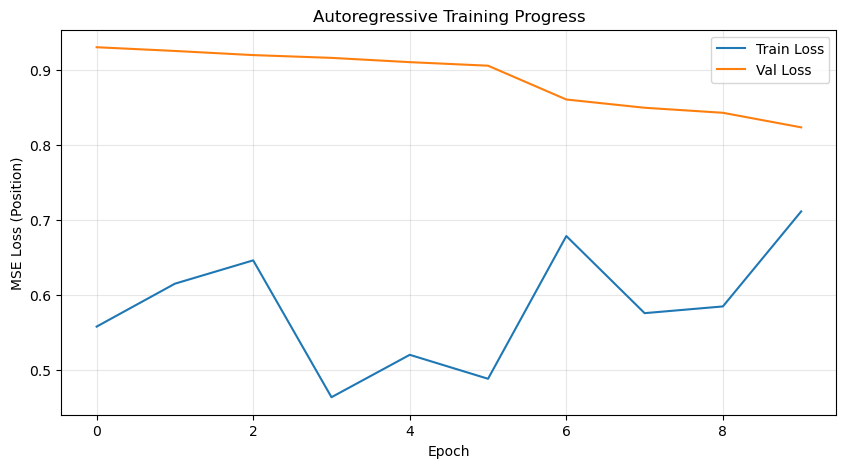

In [9]:
import sys
import os

# Add the parent directory 'experiments' to sys.path
sys.path.append(os.path.abspath('..'))

from models.PhysicModel import OmniRobotDynamic
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

# --- 2. Configuration Parameters ---
BATCH_SIZE = 32
INPUT_STEPS = 1
TARGET_STEPS = 100
DT = 0.016
EPOCHS = 10
LEARNING_RATE = 0.1
CSV_PATH = '../dataset/processed_data/data0.csv'

# --- 3. Data Preparation ---
print("Preparing data...")
# Load raw data and create sequences
df_result = load_and_prepare_timeseries_data(
    CSV_PATH, 
    sequence_length=INPUT_STEPS + TARGET_STEPS, 
    overlap=0, # No overlap for cleaner training batches
    dt=DT
)

# Create Dataset
full_dataset = RobotTrajectoryDataset(df_result, input_steps=INPUT_STEPS, target_steps=TARGET_STEPS)

# Split Train/Val (80/20)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Data ready: {len(train_dataset)} training sequences, {len(val_dataset)} validation sequences.")

# --- 4. Setup Training Objects ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

model = OmniRobotDynamic(dt=DT)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

trainer = AutoregressiveTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    dt=DT
)

# --- 5. Run Training Loop ---
print("\nStarting training (Optimizing Motor Gains & Friction)...")
print(f"Initial Motor Gains: {model.motor_gains.data}")
print(f"Initial Friction: {model.friction_coeffs.data}")

loss_history = []

for epoch in range(EPOCHS):
    train_loss = trainer.train_epoch()
    val_loss = trainer.validate()
    loss_history.append((train_loss, val_loss))
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

print("\nTraining Complete.")
print(f"Final Motor Gains: {model.motor_gains.data}")
print(f"Final Friction: {model.friction_coeffs.data}")

# --- 6. Plot Learning Curve ---
plt.figure(figsize=(10, 5))
plt.plot([l[0] for l in loss_history], label='Train Loss')
plt.plot([l[1] for l in loss_history], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss (Position)')
plt.title('Autoregressive Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [10]:
import os

# Define the path to save the model
save_dir = '../models/trained'
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, 'omni_robot_dynamic_weights.pth')

# Save the model state dictionary
torch.save(model.state_dict(), model_path)

print(f"Model weights saved to: {model_path}")

Model weights saved to: ../models/trained\omni_robot_dynamic_weights.pth



Starting training Hybrid Physics+Residual Model...


Training: 100%|██████████| 3/3 [00:00<00:00,  9.14it/s, loss=0.771]


Epoch 1/30 | Train Loss: 1.296326 | Val Loss: 1.280837


Training: 100%|██████████| 3/3 [00:00<00:00, 12.51it/s, loss=0.622]


Epoch 2/30 | Train Loss: 0.967316 | Val Loss: 1.188176


Training: 100%|██████████| 3/3 [00:00<00:00, 12.30it/s, loss=0.6]  


Epoch 3/30 | Train Loss: 0.917089 | Val Loss: 1.128740


Training: 100%|██████████| 3/3 [00:00<00:00, 10.01it/s, loss=0.705]


Epoch 4/30 | Train Loss: 0.877954 | Val Loss: 1.088080


Training: 100%|██████████| 3/3 [00:00<00:00, 10.80it/s, loss=1.22] 


Epoch 5/30 | Train Loss: 0.956971 | Val Loss: 1.107054


Training: 100%|██████████| 3/3 [00:00<00:00, 11.69it/s, loss=0.674]


Epoch 6/30 | Train Loss: 0.834313 | Val Loss: 1.169060


Training: 100%|██████████| 3/3 [00:00<00:00,  6.52it/s, loss=1.43] 


Epoch 7/30 | Train Loss: 1.148273 | Val Loss: 1.294780


Training: 100%|██████████| 3/3 [00:00<00:00,  9.60it/s, loss=1.85]


Epoch 8/30 | Train Loss: 1.377532 | Val Loss: 1.239959


Training: 100%|██████████| 3/3 [00:00<00:00, 11.33it/s, loss=1.82]


Epoch 9/30 | Train Loss: 1.489494 | Val Loss: 1.524677


Training: 100%|██████████| 3/3 [00:00<00:00, 10.54it/s, loss=1.33]


Epoch 10/30 | Train Loss: 1.484932 | Val Loss: 1.456308


Training: 100%|██████████| 3/3 [00:00<00:00, 10.72it/s, loss=1.55]


Epoch 11/30 | Train Loss: 1.471356 | Val Loss: 1.586329


Training: 100%|██████████| 3/3 [00:00<00:00, 11.63it/s, loss=1.51]


Epoch 12/30 | Train Loss: 1.546752 | Val Loss: 1.520327


Training: 100%|██████████| 3/3 [00:00<00:00, 11.29it/s, loss=1.84]


Epoch 13/30 | Train Loss: 1.695758 | Val Loss: 1.659277


Training: 100%|██████████| 3/3 [00:00<00:00,  6.95it/s, loss=1.73]


Epoch 14/30 | Train Loss: 1.712209 | Val Loss: 1.721866


Training: 100%|██████████| 3/3 [00:00<00:00, 11.56it/s, loss=1.67]


Epoch 15/30 | Train Loss: 1.762504 | Val Loss: 1.699503


Training: 100%|██████████| 3/3 [00:00<00:00, 11.22it/s, loss=1.78]


Epoch 16/30 | Train Loss: 1.755959 | Val Loss: 1.663377


Training: 100%|██████████| 3/3 [00:00<00:00, 11.79it/s, loss=1.6] 


Epoch 17/30 | Train Loss: 1.659527 | Val Loss: 1.711020


Training: 100%|██████████| 3/3 [00:00<00:00, 11.62it/s, loss=1.8] 


Epoch 18/30 | Train Loss: 1.810864 | Val Loss: 1.545358


Training: 100%|██████████| 3/3 [00:00<00:00, 11.38it/s, loss=2.07]


Epoch 19/30 | Train Loss: 1.755242 | Val Loss: 1.566250


Training: 100%|██████████| 3/3 [00:00<00:00, 10.66it/s, loss=1.53]


Epoch 20/30 | Train Loss: 1.575134 | Val Loss: 1.706965


Training: 100%|██████████| 3/3 [00:00<00:00,  5.61it/s, loss=1.58]


Epoch 21/30 | Train Loss: 1.716605 | Val Loss: 1.532408


Training: 100%|██████████| 3/3 [00:00<00:00, 10.19it/s, loss=1.64]


Epoch 22/30 | Train Loss: 1.576787 | Val Loss: 1.523098


Training: 100%|██████████| 3/3 [00:00<00:00, 10.26it/s, loss=1.82]


Epoch 23/30 | Train Loss: 1.627614 | Val Loss: 1.515364


Training: 100%|██████████| 3/3 [00:00<00:00, 10.12it/s, loss=1.31]


Epoch 24/30 | Train Loss: 1.497451 | Val Loss: 1.565132


Training: 100%|██████████| 3/3 [00:00<00:00, 10.14it/s, loss=1.49]


Epoch 25/30 | Train Loss: 1.553544 | Val Loss: 1.494668


Training: 100%|██████████| 3/3 [00:00<00:00, 10.58it/s, loss=1.52]


Epoch 26/30 | Train Loss: 1.524933 | Val Loss: 1.480970


Training: 100%|██████████| 3/3 [00:00<00:00, 10.60it/s, loss=2.12]


Epoch 27/30 | Train Loss: 1.689982 | Val Loss: 1.553273


Training: 100%|██████████| 3/3 [00:00<00:00,  5.33it/s, loss=1.5] 


Epoch 28/30 | Train Loss: 1.543897 | Val Loss: 1.483441


Training: 100%|██████████| 3/3 [00:00<00:00, 10.34it/s, loss=1.34]


Epoch 29/30 | Train Loss: 1.478410 | Val Loss: 1.545101


Training: 100%|██████████| 3/3 [00:00<00:00, 10.76it/s, loss=1.87]


Epoch 30/30 | Train Loss: 1.644261 | Val Loss: 1.508830

Hybrid Training Complete.
Hybrid model saved to ../models/trained\hybrid_physics_residual_weights.pth


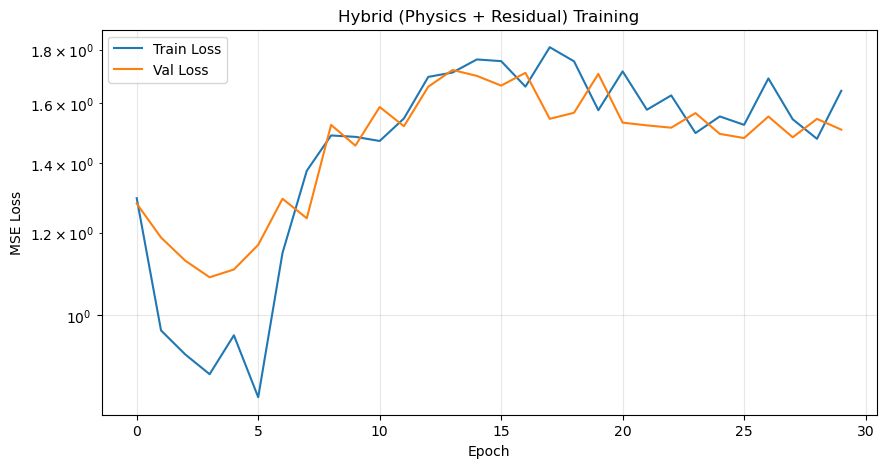

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Ensure OmniRobotDynamic is available (via import or definition above)
# from models.PhysicModel import OmniRobotDynamic

class PhysicsResidualModel(nn.Module):
    def __init__(self, physics_model, hidden_dim=64):
        """
        A hybrid model:
        1. Uses OmniRobotDynamic to get a physics-based prediction.
        2. Uses a Neural Network to predict a 'residual correction' to the physics output.
        
        v_{t+1} = Physics(v_t, cmd_t) + Network(v_t, cmd_t)
        
        Args:
            physics_model: Pre-initialized OmniRobotDynamic instance
            hidden_dim: Size of hidden layers for the residual network
        """
        super().__init__()
        self.physics_model = physics_model
        self.dt = physics_model.dt
        
        # Residual Network
        # Input: 3 (current velocities) + 3 (commands) = 6 features
        self.residual_net = nn.Sequential(
            nn.Linear(6, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 3)  # Outputs corrections: [res_vx, res_vy, res_omega]
        )

    def forward(self, current_vel, commands, theta):
        """
        Args:
            current_vel: (Batch, 3)
            commands:    (Batch, 3)
            theta:       (Batch, 1)
        """
        # 1. Physics Prediction (Base Model)
        # Note: We detach() to freeze physics gradients if we only want to train the residual,
        # otherwise gradients flow through both. Usually good to train both or freeze physics first.
        # Here we let gradients flow through both for fine-tuning.
        physics_next_vel, _ = self.physics_model(current_vel, commands, theta)
        
        # 2. Residual Prediction (Error Correction)
        inputs = torch.cat([current_vel, commands], dim=1)
        residual_correction = self.residual_net(inputs)
        
        # 3. Combine: Final Velocity = Physics Limit + Learned Correction
        final_next_vel = physics_next_vel + residual_correction
        
        # 4. Kinematics Update (using the corrected velocity)
        # theta_{t+1} = theta_t + omega_{final} * dt
        omega_new = final_next_vel[:, 2]
        theta_new = theta.squeeze() + omega_new * self.dt
        
        # Normalize theta
        theta_new = torch.atan2(torch.sin(theta_new), torch.cos(theta_new)).unsqueeze(-1)
        
        return final_next_vel, theta_new

# --- Setup Training ---
HIDDEN_DIM = 64
LEARNING_RATE = 0.001
EPOCHS = 30
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 1. Initialize Base Physics Model
base_physics_model = OmniRobotDynamic(dt=DT)
# Optional: Load pre-trained weights if available to start from a good baseline
# base_physics_model.load_state_dict(torch.load('../models/trained/omni_robot_dynamic_weights.pth'))

# 2. Initialize Hybrid Model
hybrid_model = PhysicsResidualModel(base_physics_model, hidden_dim=HIDDEN_DIM)

# 3. Optimizer
optimizer_hybrid = optim.Adam(hybrid_model.parameters(), lr=LEARNING_RATE)

# 4. Trainer
trainer_hybrid = AutoregressiveTrainer(
    model=hybrid_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_hybrid,
    device=device,
    dt=DT
)

# --- Run Training Loop ---
print(f"\nStarting training Hybrid Physics+Residual Model...")

hybrid_loss_history = []

for epoch in range(EPOCHS):
    train_loss = trainer_hybrid.train_epoch()
    val_loss = trainer_hybrid.validate()
    hybrid_loss_history.append((train_loss, val_loss))
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

print("\nHybrid Training Complete.")

# --- Save Hybrid Model ---
save_dir = '../models/trained'
os.makedirs(save_dir, exist_ok=True)
hybrid_path = os.path.join(save_dir, 'hybrid_physics_residual_weights.pth')
torch.save(hybrid_model.state_dict(), hybrid_path)
print(f"Hybrid model saved to {hybrid_path}")

# --- Plot ---
plt.figure(figsize=(10, 5))
plt.plot([l[0] for l in hybrid_loss_history], label='Train Loss')
plt.plot([l[1] for l in hybrid_loss_history], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Hybrid (Physics + Residual) Training')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

In [12]:
import os

# Define the path to save the residual hybrid model
save_dir = '../models/trained'
os.makedirs(save_dir, exist_ok=True)
hybrid_model_path = os.path.join(save_dir, 'hybrid_physics_residual_weights.pth')

# Save the model state dictionary
torch.save(hybrid_model.state_dict(), hybrid_model_path)

print(f"Hybrid Physics+Residual model weights saved to: {hybrid_model_path}")

Hybrid Physics+Residual model weights saved to: ../models/trained\hybrid_physics_residual_weights.pth
